In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

In [2]:
from tensorflow.keras.models import Model

def visualize_layer_outputs(model, image, n):
    """
    Pass an image through the first `n` layers of the model and plot output channels.

    Parameters:
    - model: Keras Sequential model
    - image: single input image (shape must match model input)
    - n: number of layers to include
    """
    # Ensure image has batch dimension
    if image.ndim == 3:
        image = np.expand_dims(image, axis=0)
    
    # Create a model up to the nth layer
    truncated_model = Model(inputs=model.inputs, outputs=model.layers[n].output)

    # Get activations
    activations = truncated_model.predict(image)
    
    # Squeeze batch dimension if needed
    if activations.ndim == 4:
        activations = np.squeeze(activations, axis=0)  # shape: (H, W, C)

    n_channels = activations.shape[-1]

    # Set up subplot grid
    n_cols = 4
    n_rows = int(np.ceil((n_channels + 1) / n_cols))  # +1 for original image
    size = 4
    
    plt.figure(figsize=(size * n_cols, size * n_rows))

    # Plot original image
    plt.subplot(n_rows, n_cols, 1)
    if image.shape[-1] == 1:
        plt.imshow(image[0, ..., 0], cmap='gray')
    else:
        plt.imshow(image[0])
    plt.title("Original")

    # Plot each channel
    for i in range(n_channels):
        plt.subplot(n_rows, n_cols, i + 2)
        plt.imshow(activations[..., i], cmap='gray', interpolation=None)
        plt.title(f"Channel {i}")

    plt.tight_layout()
    plt.show()

# Keras CNN on un-augmented CIFAR10 data

In [4]:
from tensorflow.keras.datasets import cifar10

# Load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Print shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape: ", X_test.shape)

X_train.shape: (50000, 32, 32, 3)
X_test.shape:  (10000, 32, 32, 3)


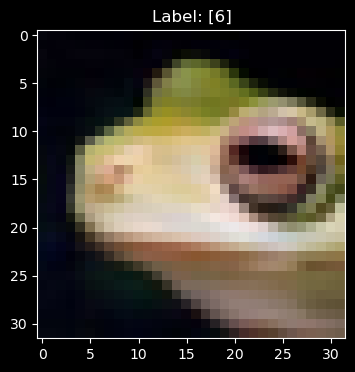

In [12]:
# Display a random image
idx = np.random.randint(0, len(X_train))
plt.figure(figsize=(4, 4))
plt.imshow(X_train[idx])
plt.title(f"Label: {y_train[idx]}")
plt.show()

## Create/train/analyze model

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

dropout_rate = 0.25

n_classes  = np.unique(y_train).shape[0]

# Create model
model = Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(8, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(dropout_rate),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    GlobalAveragePooling2D(),
    #Flatten(),
    
    Dense(n_classes, activation='softmax'),
])

# Display model summary
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)                   │ (None, 32, 32, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 16, 16, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 16, 16, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 8, 8, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 8, 8, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 4, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,402 (99.23 KB)

 Trainable params: 25,290 (98.79 KB)

 Non-trainable params: 112 (448.00 B)

In [54]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay, PolynomialDecay

# define training parameters
epochs          = 15
batch_size      = 1000

# Define the learning rate schedule
initial_learning_rate = 0.01

optimizer = Adam(
    learning_rate=initial_learning_rate,
)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

In [55]:
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.2883 - loss: 2.0191 - val_accuracy: 0.1957 - val_loss: 2.3945
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.4732 - loss: 1.4523 - val_accuracy: 0.3868 - val_loss: 1.7280
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.5165 - loss: 1.3309 - val_accuracy: 0.4428 - val_loss: 1.5947
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.5510 - loss: 1.2415 - val_accuracy: 0.5680 - val_loss: 1.2001
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.5844 - loss: 1.1638 - val_accuracy: 0.5260 - val_loss: 1.3185
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5974 - loss: 1.1270 - val_accuracy: 0.6165 - val_loss: 1.0745
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6028 - loss: 1.1057 - val_accuracy: 0.5469 - val_loss: 1.3681
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6244 - loss: 1.0584 - val_accuracy: 0.5692 - v

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_train_pred = model.predict(X_train).argmax(axis=1)
y_test_pred  = model.predict(X_test).argmax(axis=1)

# Confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test  = confusion_matrix(y_test, y_test_pred)

# 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Top-left: Training and Validation Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Top-right: Training and Validation Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# Bottom-left: Confusion Matrix (Training)
sns.heatmap(cm_train, annot=True, fmt='d', ax=axes[1, 0], vmin=0, 
            annot_kws={"size": 12}, cmap='nipy_spectral')
axes[1, 0].set_title('Confusion Matrix (Training Data)')
axes[1, 0].set_xlabel('Predicted Label')
axes[1, 0].set_ylabel('True Label')

# Bottom-right: Confusion Matrix (Test)
sns.heatmap(cm_test, annot=True, fmt='d', ax=axes[1, 1], vmin=0, 
            annot_kws={"size": 12}, cmap='nipy_spectral')
axes[1, 1].set_title('Confusion Matrix (Test Data)')
axes[1, 1].set_xlabel('Predicted Label')
axes[1, 1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Print classification report for test data
print("Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred))

## Visualize channels after processing

In [47]:
idx = np.random.choice( range(X_train.shape[0]), 1 )[0]

# Choose an image from your dataset
sample_img = X_train[idx]  # or any image shaped like your input

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


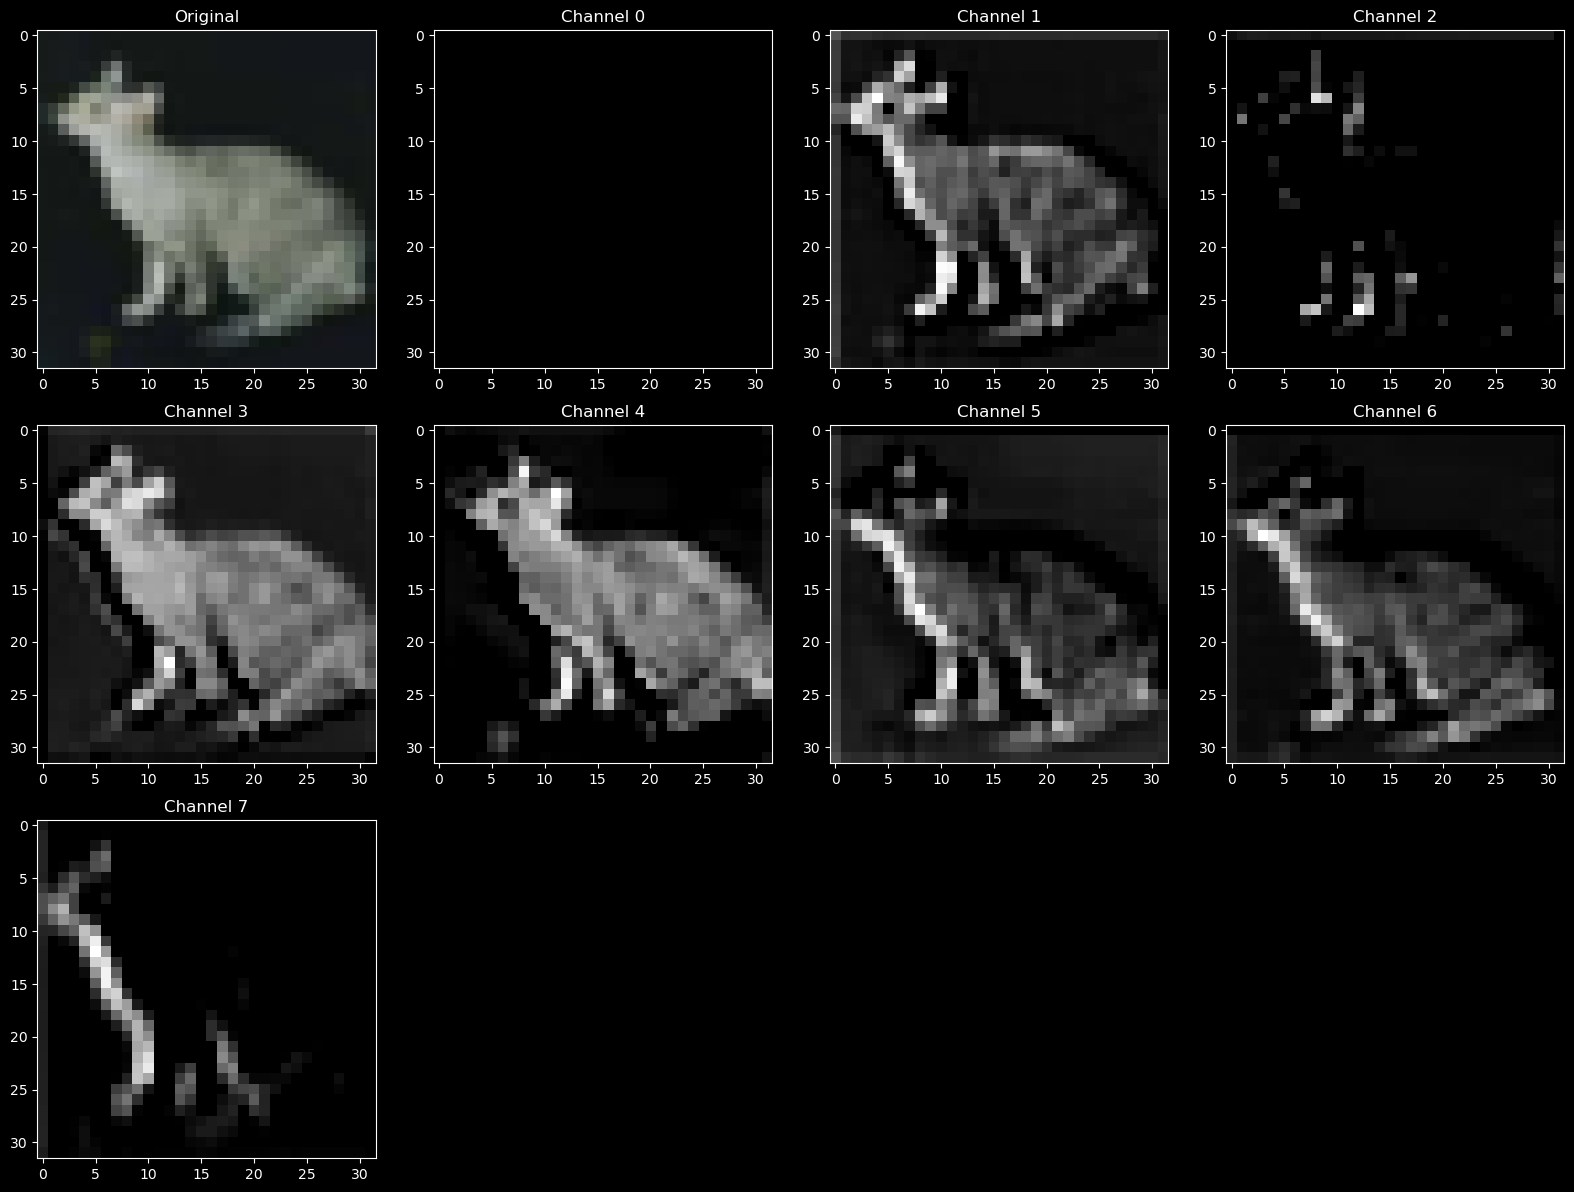

In [48]:
# Visualize up to the 2nd Conv2D layer (index 2)
visualize_layer_outputs(model, sample_img, n=0)